In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# TA-Lib for indicators
import talib

# PyNance and PyFolio will be used later, we just import them now
import talib                      # technical indicators
import pynance as py              # from GitHub version
import quantstats as qs   

# Make plots a bit nicer
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


## Load or download a data (NVDA)

In [2]:
# ============================================
# Download META daily data for a year
# ============================================

ticker = "NVDA"
start_date = "2009-01-01"
end_date   = "2023-12-29"

df = yf.download(ticker, start=start_date, end=end_date, progress=False) 
df.head()


C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_3640\249889976.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000
2009-01-05,0.203319,0.207904,0.195984,0.197360,705736000
2009-01-06,0.210196,0.216156,0.204695,0.209279,657904000
2009-01-07,0.197589,0.205382,0.190483,0.205382,870096000
2009-01-08,0.192546,0.195067,0.180626,0.195067,1014496000


# 1. Data profiling

In [3]:
# ============================================
# Clean the columns (handle MultiIndex case)
# ============================================

# If columns are MultiIndex (like: ('Close', 'NVDA')), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  # keep only first level: Open, High, etc.

print("Cleaned columns:", df.columns.tolist())

# Optional: add a Ticker column (useful if using multiple tickers later)
df["Ticker"] = ticker

# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()




Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# - Summary Statistics 

In [4]:
# log the shape of dataset and the first five rows of dataset
print(f'the shape of NVDA dataset ${df.shape}')
df.head()

the shape of NVDA dataset $(3773, 6)


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000,NVDA
2009-01-05,0.203319,0.207904,0.195984,0.197360,705736000,NVDA
2009-01-06,0.210196,0.216156,0.204695,0.209279,657904000,NVDA
2009-01-07,0.197589,0.205382,0.190483,0.205382,870096000,NVDA
2009-01-08,0.192546,0.195067,0.180626,0.195067,1014496000,NVDA


In [5]:
# log the last examples of this dataset
df.tail()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2023-12-21,48.965446,49.070393,48.394730,48.786535,300425000,NVDA
2023-12-22,48.805527,49.358247,48.442706,49.170342,252507000,NVDA
2023-12-26,49.254299,49.575137,48.935459,48.943454,244200000,NVDA
2023-12-27,49.392231,49.655100,49.060397,49.486186,233648000,NVDA
2023-12-28,49.497185,49.859003,49.387239,49.618126,246587000,NVDA


In [6]:
# log the last examples of this dataset
df.sample(5)

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2017-06-05,3.653699,3.666536,3.517929,3.529532,817376000,NVDA
2014-07-22,0.439394,0.447006,0.438442,0.444627,298816000,NVDA
2015-03-06,0.543192,0.550178,0.542710,0.547528,257392000,NVDA
2009-10-12,0.321139,0.327328,0.319076,0.319305,499008000,NVDA
2010-01-13,0.410536,0.411911,0.391969,0.407785,508868000,NVDA


In [7]:
# check more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2009-01-02 to 2023-12-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3773 non-null   float64
 1   High    3773 non-null   float64
 2   Low     3773 non-null   float64
 3   Open    3773 non-null   float64
 4   Volume  3773 non-null   int64  
 5   Ticker  3773 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 206.3+ KB


In [8]:
# check if a null value exists
print("Check for missing values:")
df.isna().sum()

Check for missing values:


Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

In [9]:
# 1. Calculate the percentage of missing values for every column
null_percentages = df.isnull().sum() / len(df) * 100

# 2. Filter the resulting Series for percentages greater than 5
columns_with_high_nulls = null_percentages[null_percentages > 5]

# 3. Print the results
print("Columns with >5% Null Values:")
print(columns_with_high_nulls)

Columns with >5% Null Values:
Series([], dtype: float64)


In [10]:
# Check if null rows exist
# 1. Define the critical columns
key_cols = ['Close', 'Open', 'High', 'Volume', 'Ticker']

# 2. Create a boolean mask:
missing_rows_mask = df[key_cols].isnull().any(axis=1)

# 3. Use the mask to display the subset of rows with missing data
missing_value_rows = df[missing_rows_mask]

# 4. Display the resulting DataFrame
print(f"Total rows with missing values in the key columns: {len(missing_value_rows)}")
print("Rows with Missing Data (only showing the key columns for focus):")
print(missing_value_rows[key_cols])

Total rows with missing values in the key columns: 0
Rows with Missing Data (only showing the key columns for focus):
Empty DataFrame
Columns: [Close, Open, High, Volume, Ticker]
Index: []


In [11]:
# log statistical data values
print("The description of the numeric columns:")
print(df.describe())

The description of the numeric columns:
Price        Close         High          Low         Open        Volume
count  3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03
mean      6.785504     6.904301     6.655573     6.782145  5.231108e+08
std      10.638466    10.822280    10.440332    10.637537  3.206111e+08
min       0.165269     0.171228     0.162289     0.165269  4.564400e+07
25%       0.357334     0.362399     0.351706     0.356911  3.188240e+08
50%       1.167181     1.175526     1.157362     1.165217  4.495800e+08
75%       6.994345     7.090012     6.844059     6.938922  6.420240e+08
max      50.379307    50.518225    49.387239    50.182292  3.692928e+09


In [12]:
#Overview of categorical columns
print("The description of the categorical columns:")
print(df.describe(include=['object']))

The description of the categorical columns:
Price  Ticker
count    3773
unique      1
top      NVDA
freq     3773


In [13]:
# log and check the frequency, and uniqueness of all dataset column
print("The description of all columns:")
print(df.describe(include='all'))


The description of all columns:
Price         Close         High          Low         Open        Volume  \
count   3773.000000  3773.000000  3773.000000  3773.000000  3.773000e+03   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean       6.785504     6.904301     6.655573     6.782145  5.231108e+08   
std       10.638466    10.822280    10.440332    10.637537  3.206111e+08   
min        0.165269     0.171228     0.162289     0.165269  4.564400e+07   
25%        0.357334     0.362399     0.351706     0.356911  3.188240e+08   
50%        1.167181     1.175526     1.157362     1.165217  4.495800e+08   
75%        6.994345     7.090012     6.844059     6.938922  6.420240e+08   
max       50.379307    50.518225    49.387239    50.182292  3.692928e+09   

Price  Ticker  
count    3773  
unique      1  
top    

In [14]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [15]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'Ticker': 1}


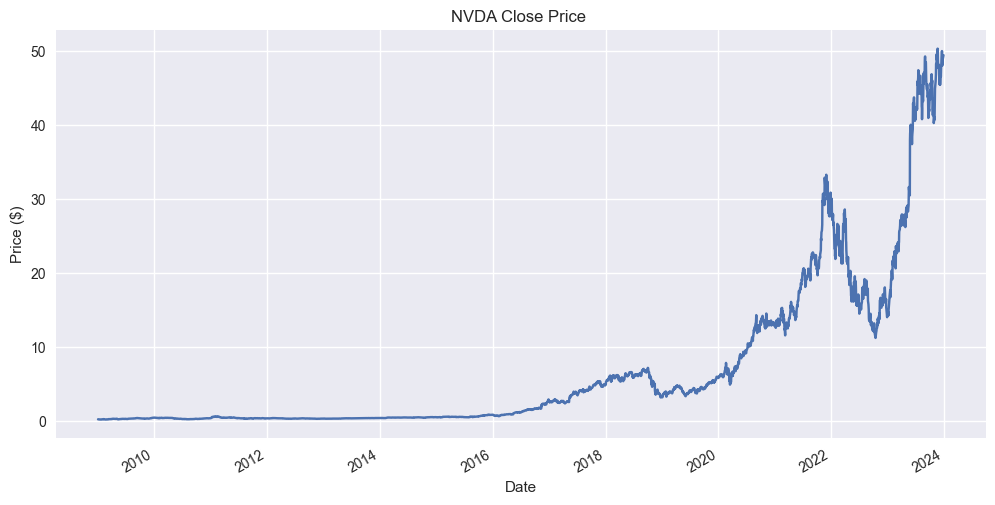

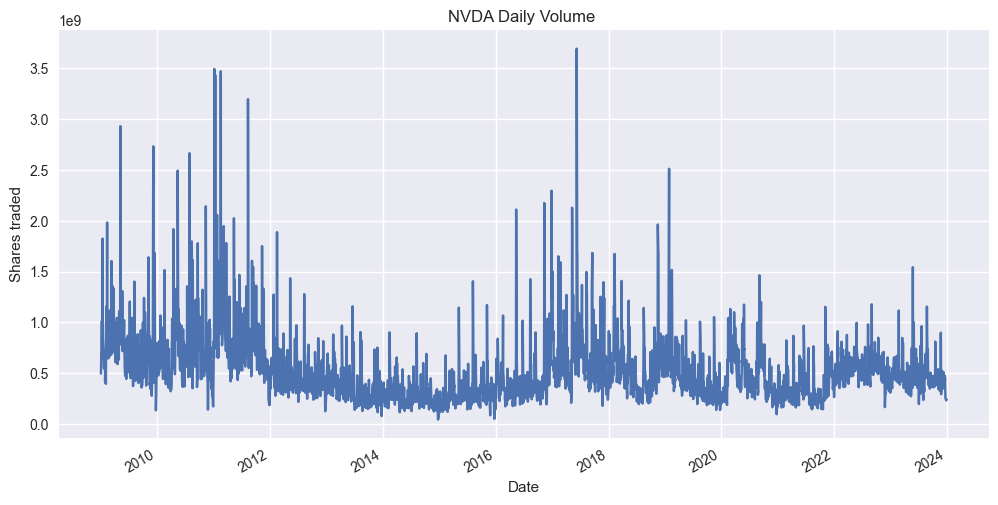

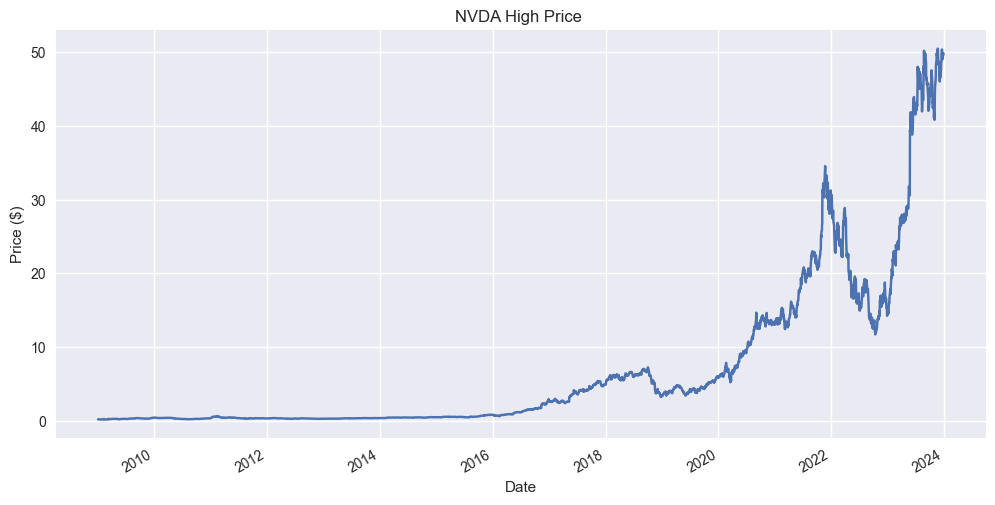

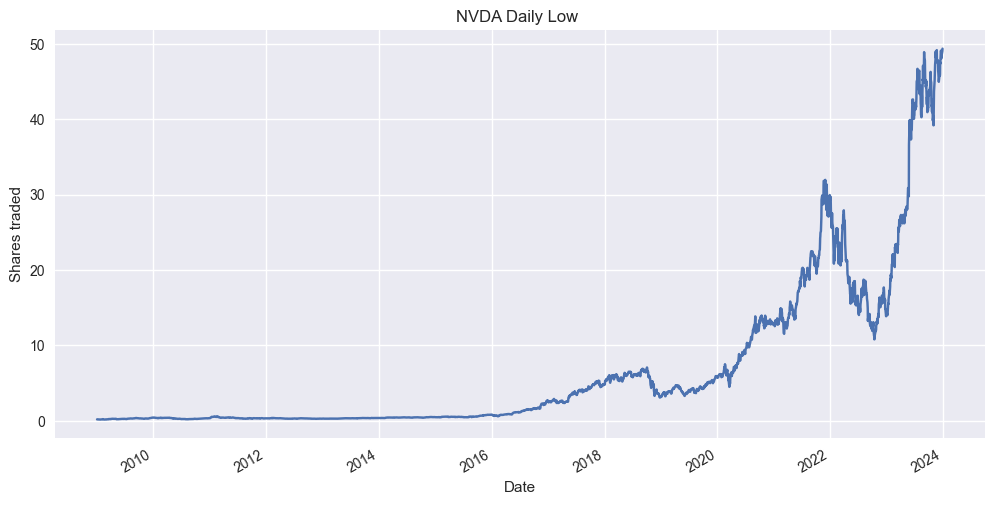

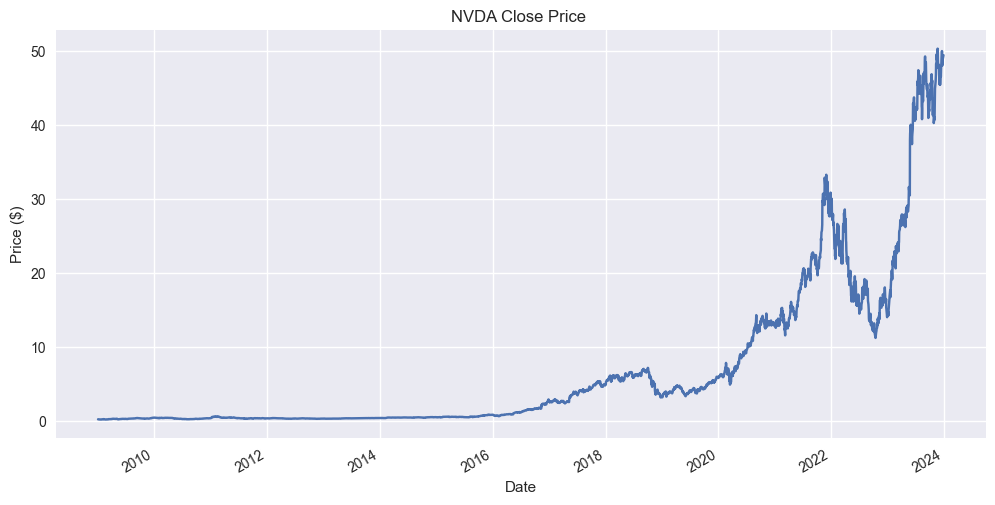

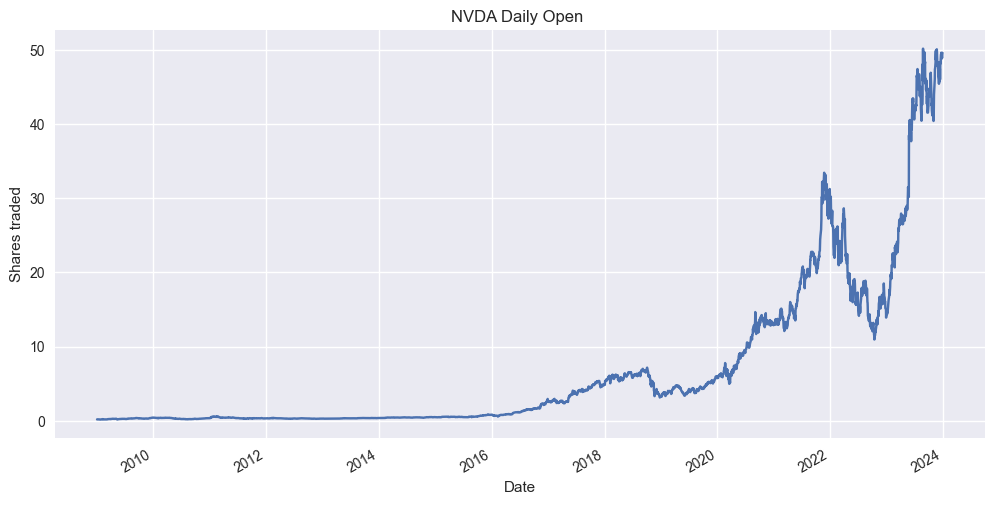

In [16]:
# ============================================
# Quick look at price and volume
# ============================================

# Close price chart
df["Close"].plot(title="NVDA Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Volume"].plot(title="NVDA Daily Volume ")
plt.ylabel("Shares traded")
plt.show()
df["High"].plot(title="NVDA High Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Low"].plot(title="NVDA Daily Low ")
plt.ylabel("Shares traded")
plt.show()
df["Close"].plot(title="NVDA Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Open"].plot(title="NVDA Daily Open ")
plt.ylabel("Shares traded")
plt.show()


## Stock price over time

## NVDA Close Price Chart Analysis
- The image displays a line chart tracking the Close Price for NVDA (NVIDIA Corporation) stock over a long-term period, from approximately 2008/2009 up to early 2024.

Key Observations:
- Long Period of Stability (Pre-2016): From the start of the chart (around 2009) until approximately 2016, the stock price remained relatively flat, hovering close to the $0 mark and not exceeding $5.

- Initial Growth Phase (2016 - 2021): Around 2016, the stock began a significant upward trend, rising steadily and crossing the $10 mark around 2020 and the $20 mark around 2021.

- Volatility and Sharp Rise (2021 - 2023): The period from late 2021 to 2023 shows increased volatility:

- The price peaked near the $35 mark in late 2021/early 2022.

- This was followed by a substantial decline, with the price dropping significantly towards the $10 mark in late 2022.

- Explosive Growth (2023 - 2024): Starting around early 2023, the stock price entered a period of meteoric and accelerated growth, reaching new, unprecedented highs.

- The price surged rapidly from the $10-$15 range to peak near the $50 mark by early 2024, representing the highest price on the chart.

In [17]:
# ============================================
# Compute technical indicators with TA-Lib
# ============================================

# Use 'Adj Close' if available, otherwise 'Close'
if "Adj Close" in df.columns:
    price = df["Adj Close"]
else:
    price = df["Close"]

# --- Moving Averages ---
df["SMA_20"] = talib.SMA(price, timeperiod=20)
df["SMA_50"] = talib.SMA(price, timeperiod=50)
df["EMA_20"] = talib.EMA(price, timeperiod=20)

# --- RSI ---
df["RSI_14"] = talib.RSI(price, timeperiod=14)

# --- MACD ---
df["MACD"], df["MACD_signal"], df["MACD_hist"] = talib.MACD(
    price, fastperiod=12, slowperiod=26, signalperiod=9
)


df.tail()


Price,Close,High,Low,Open,Volume,Ticker,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,
2023-12-21,48.965446,49.070393,48.394730,48.786535,300425000,NVDA,47.654100,46.220013,47.942445,56.175507,0.643584,0.546959,0.096626
2023-12-22,48.805527,49.358247,48.442706,49.170342,252507000,NVDA,47.706983,46.257777,48.024643,55.352115,0.634352,0.564437,0.069915
2023-12-26,49.254299,49.575137,48.935459,48.943454,244200000,NVDA,47.759019,46.334178,48.141753,57.245965,0.655689,0.582688,0.073001
2023-12-27,49.392231,49.655100,49.060397,49.486186,233648000,NVDA,47.838988,46.400666,48.260846,57.837921,0.675937,0.601338,0.074600
2023-12-28,49.497185,49.859003,49.387239,49.618126,246587000,NVDA,47.908265,46.512367,48.378593,58.310912,0.692470,0.619564,0.072906


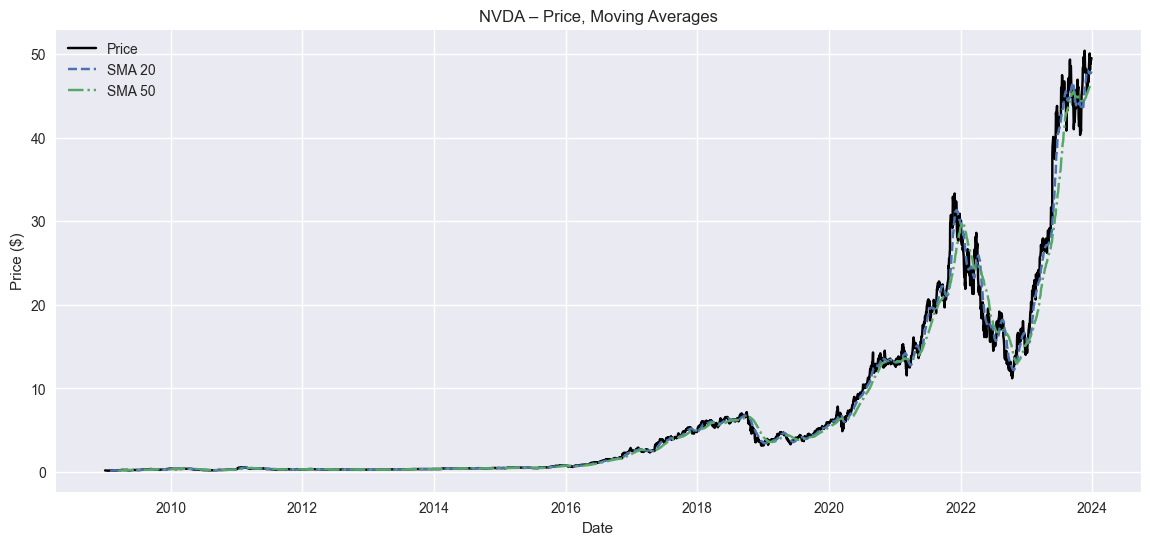

In [18]:
# ============================================
# Price + SMA + Bollinger Bands
# ============================================

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, price, label="Price", color="black")
ax.plot(df.index, df["SMA_20"], label="SMA 20", linestyle="--")
ax.plot(df.index, df["SMA_50"], label="SMA 50", linestyle="-.")


ax.set_title("NVDA – Price, Moving Averages")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.legend()
plt.show()


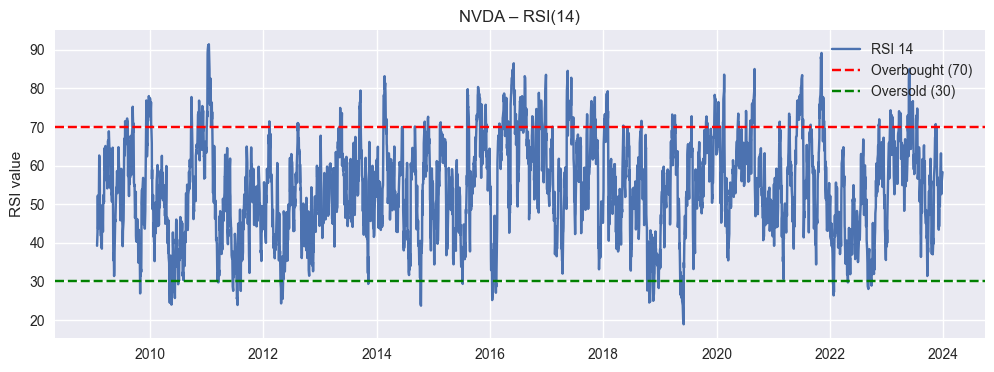

In [19]:
# ============================================
# RSI – Overbought / Oversold
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["RSI_14"], label="RSI 14")
ax.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax.axhline(30, color="green", linestyle="--", label="Oversold (30)")

ax.set_title("NVDA – RSI(14)")
ax.set_ylabel("RSI value")
ax.legend()
plt.show()


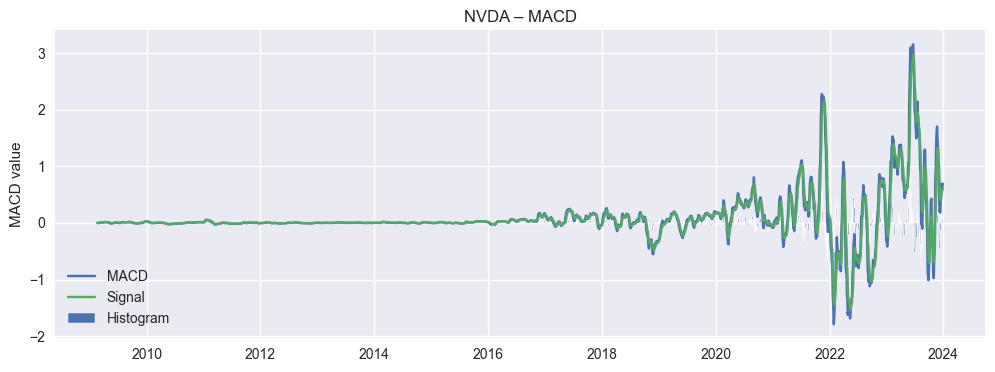

In [20]:
# ============================================
# MACD – Trend & momentum
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["MACD"], label="MACD")
ax.plot(df.index, df["MACD_signal"], label="Signal")
ax.bar(df.index, df["MACD_hist"], label="Histogram")

ax.set_title("NVDA – MACD")
ax.set_ylabel("MACD value")
ax.legend()
plt.show()


## NVDA - Price, Moving Averages Chart Analysis
The chart shows:

Price (Black Solid Line): The actual closing price of NVDA stock.

- SMA 20 (Blue Dashed Line): The Simple Moving Average over 20 periods (likely 20 trading days). This is a shorter-term trend line.

- SMA 50 (Green Dotted Line): The Simple Moving Average over 50 periods (likely 50 trading days). This is a medium-term trend line.

Key Technical Observations:
1. Bullish Confirmation (Post-2016 and 2023):

- Throughout the main uptrends (2016-2021 and the explosive rise in 2023), the Price line is generally above both the SMA 20 and SMA 50.

- Additionally, the SMA 20 is above the SMA 50 (a "golden cross" or bullish crossover often occurs when the short-term average crosses above the long-term average, which is maintained throughout strong uptrends). This configuration confirms a strong, sustained upward momentum.

2. Bearish Confirmation (2022 Downtrend):

- During the significant price decline in 2022, the Price line dropped below both moving averages.

- The SMA 20 crossed below the SMA 50 (a "death cross" or bearish crossover), signaling a change to a strong downtrend.

3. Current Trend (Late 2023 - Early 2024):

- The chart ends with the price in a steep ascent.

- The Price is far above both SMAs, and the SMA 20 is sharply above the SMA 50, indicating very strong, current bullish momentum.

4. Support/Resistance: The moving averages often act as dynamic support or resistance levels. For instance, in the 2018-2020 period, the price frequently bounced off the SMAs before continuing higher.

## NVDA - Relative Strength Index (RSI 14) Analysis
- The RSI is a momentum oscillator used in technical analysis that measures the speed and change of price movements. It oscillates between 0 and 100. The chart shows the RSI calculated over a 14-period window (typically 14 trading days).

Key Components of the Chart:

- Overbought (70) (Red Dashed Line): When the RSI crosses above this line, it traditionally suggests the asset is becoming overbought and may be due for a price correction or consolidation.

- Oversold (30) (Green Dashed Line): When the RSI crosses below this line, it traditionally suggests the asset is becoming oversold and may be due for a price bounce.

Technical Observations:
- Frequent Fluctuation: The RSI line is extremely volatile, frequently oscillating between the 30 and 70 levels throughout the entire period (2009-2024). This is typical for momentum indicators.

- Extended Overbought Periods: The RSI frequently spikes above the 70 (Overbought) line. Noticeable prolonged periods include:

- Around 2016 (coinciding with the start of the major price breakout in your first chart).

Multiple times between 2019 and 2021.

- During the explosive rally in 2023 and early 2024, where the RSI is peaking near the 90 mark, indicating exceptionally strong short-term momentum.

- Oversold Signals: The RSI also drops below the 30 (Oversold) line at various points:

Around 2010 and 2011.

- Notably, in late 2018 and late 2022. These oversold signals coincided with significant price troughs, and in both cases, the price subsequently rebounded sharply.

- The dip in late 2022 corresponds exactly with the price bottom observed in the first two charts before the massive rally began.


- Price Chart: Shows the dramatic, explosive price rise in 2023-2024.

- Moving Averages Chart: Confirms the strength of the bullish trend, with the price well above the SMAs.

- RSI Chart: Indicates the current momentum is extremely high (peaking near 90), which historically suggests the stock is significantly overbought in the short term. The late 2022 dip below 30 provided a strong signal that preceded the historic bull run.

## NVDA - MACD Analysis
- The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price.

Key Components of the Chart:
- MACD Line (Blue Line): This is the difference between the 12-period Exponential Moving Average (EMA) and the 26-period EMA.

- Signal Line (Green Line): This is the 9-period EMA of the MACD Line itself.

- Histogram (Blue Bars): This is the difference between the MACD Line and the Signal Line. The height of the bars indicates the strength of the momentum.

Technical Observations and Signals:
- Long Period Near Zero (Pre-2017): For many years, the MACD hovered near the zero line, confirming the low volatility and flat price action seen in your first chart.

- Breakout and Trend Confirmation (Post-2017):

- As the price began its ascent around 2017, the MACD lines move above the zero line, which is a bullish signal that confirms the price is in an uptrend.

- The values begin to become more erratic and volatile, reflecting the increasing price swings.

Bullish Crossover Signals (2023 Rally):

- A bullish crossover occurs when the MACD Line (Blue) crosses above the Signal Line (Green). This is a common buy signal.

- The most significant bullish signal occurs in early 2023 when the MACD crosses the signal line and quickly rises well above the zero line, perfectly coinciding with the start of the massive, explosive price rally.

Current Status (Late 2023 - Early 2024):

- The chart ends with the MACD lines at their highest level ever (near the value of 3), indicating unprecedented bullish momentum and strength.

- The Histogram bars are very tall, confirming the extreme divergence and momentum.

- A recent crossover (or near-crossover) appears near the end of the chart, showing a potential momentary pullback or slowing of momentum, but the overall trend remains overwhelmingly positive and extreme.